Cleaning outliers in baseline dataset:
Removed 0 outliers from column cpu 0 using IQR method
Removed 0 outliers from column cpu 1 using IQR method
Removed 0 outliers from column cpu 2 using IQR method
Removed 13 outliers from column cpu 3 using IQR method
Removed 20 outliers from column cpu 4 using IQR method
Removed 8 outliers from column cpu 5 using IQR method
Removed 0 outliers from column cpu 6 using IQR method
Removed 12 outliers from column cpu 7 using IQR method
Removed 0 outliers from column cpu 8 using IQR method
Removed 0 outliers from column cpu 9 using IQR method
Removed 0 outliers from column cpu 0 using IQR method
Removed 0 outliers from column cpu 1 using IQR method
Removed 0 outliers from column cpu 2 using IQR method
Removed 0 outliers from column cpu 3 using IQR method
Removed 0 outliers from column cpu 4 using IQR method
Removed 0 outliers from column cpu 5 using IQR method
Removed 0 outliers from column cpu 6 using IQR method
Removed 0 outliers from column cpu 7 usi

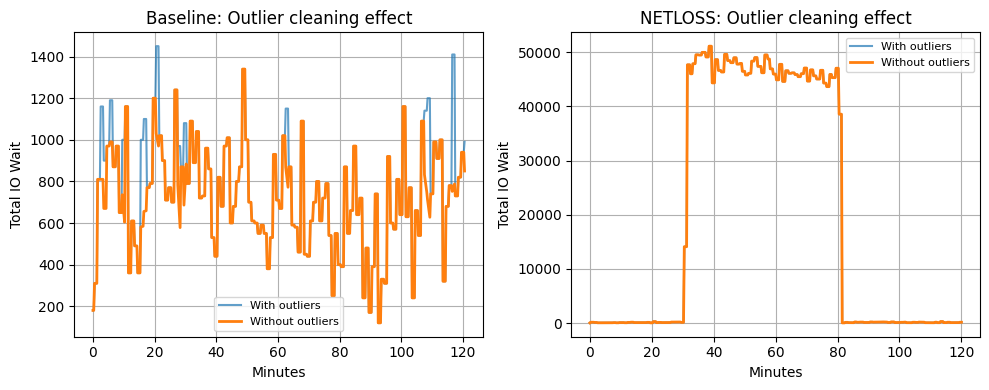

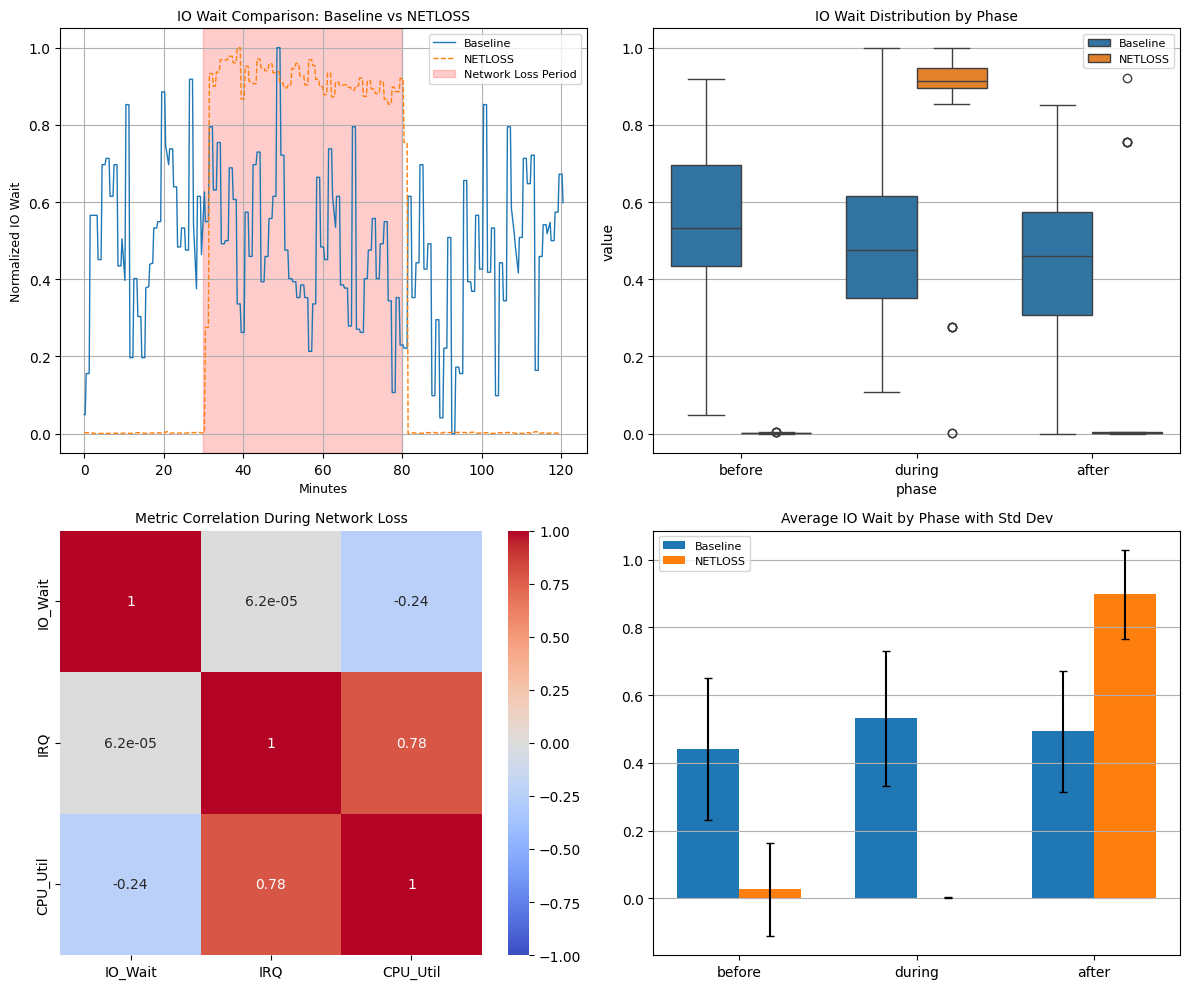

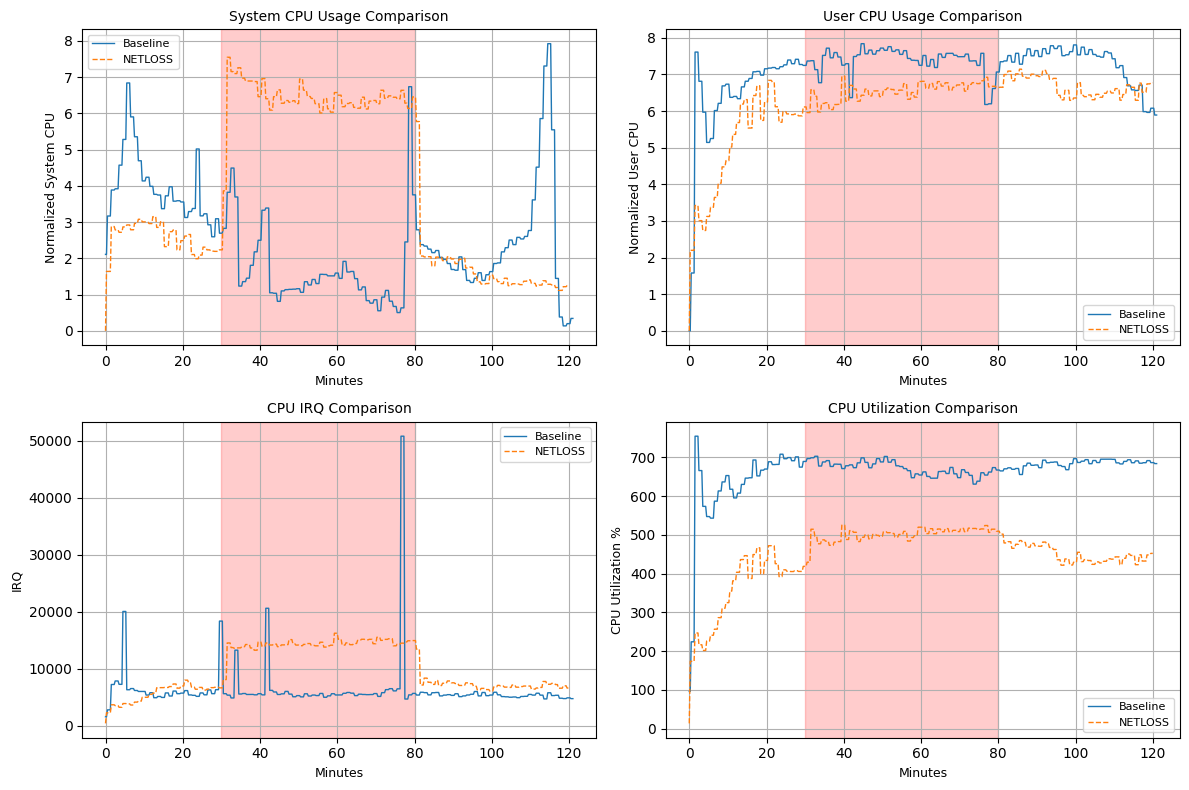

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


df_iowait = pd.read_csv("cpu_iowait.csv")
df_cpu_irq = pd.read_csv("cpu_irq.csv")
df_system_msec = pd.read_csv("cpu_system_msec.csv")
df_user_msec = pd.read_csv("cpu_user_msec.csv")
df_cpu_util = pd.read_csv("cpu_util_per.csv")

df_baseline_iowait = pd.read_csv("../../baseline/cpu related/cpu_iowait.csv")
df_baseline_irq = pd.read_csv("../../baseline/cpu related/cpu_irq.csv")
df_baseline_system_msec = pd.read_csv("../../baseline/cpu related/cpu_system_msec.csv")
df_baseline_user_msec = pd.read_csv("../../baseline/cpu related/cpu_user_msec.csv")
df_baseline_util_per = pd.read_csv("../../baseline/cpu related/cpu_util_per.csv")

df_iowait["source"] = "NETLOSS"
df_cpu_irq["source"] = "NETLOSS"
df_system_msec["source"] = "NETLOSS"
df_user_msec["source"] = "NETLOSS"
df_cpu_util["source"] = "NETLOSS"

df_baseline_iowait["source"] = "BASELINE"
df_baseline_irq["source"] = "BASELINE"
df_baseline_system_msec["source"] = "BASELINE"
df_baseline_user_msec["source"] = "BASELINE"
df_baseline_util_per["source"] = "BASELINE"

df_iowait["Time"] = pd.to_datetime(df_iowait["Time"])
df_cpu_irq["Time"] = pd.to_datetime(df_cpu_irq["Time"])
df_system_msec["Time"] = pd.to_datetime(df_system_msec["Time"])
df_user_msec["Time"] = pd.to_datetime(df_user_msec["Time"])
df_cpu_util["Time"] = pd.to_datetime(df_cpu_util["Time"])

df_baseline_iowait["Time"] = pd.to_datetime(df_baseline_iowait["Time"])
df_baseline_irq["Time"] = pd.to_datetime(df_baseline_irq["Time"])
df_baseline_system_msec["Time"] = pd.to_datetime(df_baseline_system_msec["Time"]) 
df_baseline_user_msec["Time"] = pd.to_datetime(df_baseline_user_msec["Time"])
df_baseline_util_per["Time"] = pd.to_datetime(df_baseline_util_per["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_iowait["Time"].min() - df_iowait["Time"].min()
df_iowait["Time"] += time_offset
df_cpu_irq["Time"] += time_offset
df_system_msec["Time"] += time_offset
df_user_msec["Time"] += time_offset
df_cpu_util["Time"] += time_offset

all_dfs = [
    df_iowait, df_cpu_irq, df_system_msec, df_user_msec, df_cpu_util,
    df_baseline_iowait, df_baseline_irq, df_baseline_system_msec, 
    df_baseline_user_msec, df_baseline_util_per
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

cpu_cols = [col for col in df_baseline_iowait.columns if col.startswith('cpu')]


def remove_outliers(df, columns, method='iqr', threshold=1.5):
    df_clean = df.copy()
    
    if method == 'iqr':
        for col in columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    
            df_clean.loc[outlier_mask, col] = np.nan
            
            n_outliers = outlier_mask.sum()
            print(f"Removed {n_outliers} outliers from column {col} using IQR method")
            
    elif method == 'zscore':
        for col in columns:
            z_scores = np.abs(stats.zscore(df[col].dropna()))
            outlier_mask = pd.Series(False, index=df.index)
            outlier_mask.loc[df[col].dropna().index] = z_scores > threshold
            
            df_clean.loc[outlier_mask, col] = np.nan
            
            n_outliers = outlier_mask.sum()
            print(f"Removed {n_outliers} outliers from column {col} using Z-score method")
    
    return df_clean

print("Cleaning outliers in baseline dataset:")
df_baseline_iowait_clean = remove_outliers(df_baseline_iowait, cpu_cols, method='iqr', threshold=2.0)
df_iowait_clean = remove_outliers(df_iowait, cpu_cols, method='iqr', threshold=2.0)

for col in cpu_cols:
    df_baseline_iowait_clean[col] = df_baseline_iowait_clean[col].interpolate(method='linear')
    df_iowait_clean[col] = df_iowait_clean[col].interpolate(method='linear')

def normalize_df(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# Normalize all datasets
df_baseline_iowait_norm = normalize_df(df_baseline_iowait_clean, cpu_cols)
df_iowait_norm = normalize_df(df_iowait_clean, cpu_cols)
df_irq_norm = normalize_df(df_cpu_irq, [col for col in df_cpu_irq.columns if col.startswith('cpu')])
df_util_norm = normalize_df(df_cpu_util, [col for col in df_cpu_util.columns if col.startswith('cpu')])

# Calculate total metrics (sum of all CPUs)
df_baseline_iowait_clean['Total'] = df_baseline_iowait_clean[cpu_cols].sum(axis=1)
df_iowait_clean['Total'] = df_iowait_clean[cpu_cols].sum(axis=1)
df_irq_norm['Total'] = df_irq_norm[[col for col in df_irq_norm.columns if col.startswith('cpu')]].sum(axis=1)
df_util_norm['Total'] = df_util_norm[[col for col in df_util_norm.columns if col.startswith('cpu')]].sum(axis=1)

# Normalize totals as well
df_baseline_iowait_norm['Total'] = (df_baseline_iowait_clean['Total'] - df_baseline_iowait_clean['Total'].min()) / (df_baseline_iowait_clean['Total'].max() - df_baseline_iowait_clean['Total'].min())
df_iowait_norm['Total'] = (df_iowait_clean['Total'] - df_iowait_clean['Total'].min()) / (df_iowait_clean['Total'].max() - df_iowait_clean['Total'].min())


plt.figure(figsize=(10, 4))  

plt.subplot(1, 2, 1)
plt.plot(df_baseline_iowait['Minutes'], df_baseline_iowait[cpu_cols].sum(axis=1), label='With outliers', alpha=0.7)
plt.plot(df_baseline_iowait_clean['Minutes'], df_baseline_iowait_clean['Total'], label='Without outliers', linewidth=2)
plt.title('Baseline: Outlier cleaning effect')
plt.xlabel('Minutes')
plt.ylabel('Total IO Wait')
plt.legend(fontsize=8)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_iowait['Minutes'], df_iowait[cpu_cols].sum(axis=1), label='With outliers', alpha=0.7)
plt.plot(df_iowait_clean['Minutes'], df_iowait_clean['Total'], label='Without outliers', linewidth=2)
plt.title('NETLOSS: Outlier cleaning effect')
plt.xlabel('Minutes')
plt.ylabel('Total IO Wait')
plt.legend(fontsize=8)
plt.grid(True)

plt.tight_layout()

delay_minutes = delay 
duration_minutes = duration 

def add_phase_column(df):
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

df_baseline_iowait_norm = add_phase_column(df_baseline_iowait_norm)
df_iowait_norm = add_phase_column(df_iowait_norm)
df_irq_norm = add_phase_column(df_irq_norm)
df_util_norm = add_phase_column(df_util_norm)


# 1. Statistics by phase (mean, std, min, max)
stats_baseline = df_baseline_iowait_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
stats_test = df_iowait_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])

# 2. Variance analysis
df_combined = pd.DataFrame({
    'Baseline': df_baseline_iowait_norm['Total'],
    'NETLOSS': df_iowait_norm['Total'],
    'Minutes': df_baseline_iowait_norm['Minutes'],
    'phase': df_baseline_iowait_norm['phase'],
    'difference': df_iowait_norm['Total'] - df_baseline_iowait_norm['Total']
})

# 3. T-test to verify statistical significance
t_tests = {}
for phase in ['before', 'during', 'after']:
    data = df_combined[df_combined['phase'] == phase]
    t_stat, p_value = stats.ttest_ind(data['Baseline'].dropna(), data['NETLOSS'].dropna())
    t_tests[phase] = {'t': t_stat, 'p': p_value}

# 4. Calculate percentage impact of network loss
impact = {}
for phase in ['before', 'during', 'after']:
    baseline = stats_baseline.loc[phase, 'mean']
    test = stats_test.loc[phase, 'mean']
    impact[phase] = ((test - baseline) / baseline) * 100 if baseline != 0 else float('inf')

fig = plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(df_baseline_iowait_norm['Minutes'], df_baseline_iowait_norm['Total'], label='Baseline', linewidth=1)
plt.plot(df_iowait_norm['Minutes'], df_iowait_norm['Total'], label='NETLOSS', linewidth=1, linestyle='--')
plt.axvspan(delay_minutes, delay_minutes + duration_minutes, color='red', alpha=0.2, label="Network Loss Period")
plt.title("IO Wait Comparison: Baseline vs NETLOSS", fontsize=10)
plt.xlabel("Minutes", fontsize=9)
plt.ylabel("Normalized IO Wait", fontsize=9)
plt.grid(True)
plt.legend(fontsize=8)

# 2. Box plot: distribution by phase
plt.subplot(2, 2, 2)
box_data = pd.melt(df_combined[['Baseline', 'NETLOSS', 'phase']], 
                  id_vars=['phase'], var_name='source', value_name='value')
sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
plt.title('IO Wait Distribution by Phase', fontsize=10)
plt.grid(axis='y')
plt.legend(fontsize=8)

# 3. Heatmap: correlation between metrics during failures
plt.subplot(2, 2, 3)
during_test = df_combined[df_combined['phase'] == 'during']
during_irq = df_irq_norm[df_irq_norm['phase'] == 'during']['Total'].reset_index(drop=True)
during_util = df_util_norm[df_util_norm['phase'] == 'during']['Total'].reset_index(drop=True)

# Ensure same length for all metrics
min_len = min(len(during_test), len(during_irq), len(during_util))
corr_data = pd.DataFrame({
    'IO_Wait': during_test['NETLOSS'][:min_len],
    'IRQ': during_irq[:min_len],
    'CPU_Util': during_util[:min_len]
})

sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=plt.gca())
plt.title('Metric Correlation During Network Loss', fontsize=10)

# 4. Statistics visualization
plt.subplot(2, 2, 4)
phases = ['before', 'during', 'after']
x = np.arange(len(phases))
width = 0.35

plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline')
plt.bar(x + width/2, stats_test['mean'], width, label='NETLOSS')

# Add error bars
plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], fmt='none', ecolor='black', capsize=3)
plt.errorbar(x + width/2, stats_test['mean'], yerr=stats_test['std'], fmt='none', ecolor='black', capsize=3)

plt.title('Average IO Wait by Phase with Std Dev', fontsize=10)
plt.xticks(x, phases)
plt.legend(fontsize=8)
plt.grid(axis='y')

plt.tight_layout()

# Print numerical results
print("\n--- IO WAIT STATISTICS BY PHASE (CLEAN DATA) ---")
print(stats_baseline)
print("\n", stats_test)

print("\n--- STATISTICAL TESTS ---")
for phase, test in t_tests.items():
    sig = "Significant" if test['p'] < 0.05 else "Not significant"
    print(f"{phase}: t={test['t']:.2f}, p={test['p']:.4f} ({sig})")

print("\n--- PERCENTAGE IMPACT OF NETWORK LOSS ---")
for phase, change in impact.items():
    print(f"{phase}: {change:.2f}%")

plt.show()

fig2 = plt.figure(figsize=(12, 8))
cpu_sys_cols = [col for col in df_system_msec.columns if col.startswith('cpu')]
cpu_user_cols = [col for col in df_user_msec.columns if col.startswith('cpu')]

df_system_msec_norm = normalize_df(df_system_msec, cpu_sys_cols)
df_baseline_system_msec_norm = normalize_df(df_baseline_system_msec, cpu_sys_cols)
df_user_msec_norm = normalize_df(df_user_msec, cpu_user_cols)
df_baseline_user_msec_norm = normalize_df(df_baseline_user_msec, cpu_user_cols)

# Calculate totals
df_system_msec_norm['Total'] = df_system_msec_norm[cpu_sys_cols].sum(axis=1)
df_baseline_system_msec_norm['Total'] = df_baseline_system_msec_norm[cpu_sys_cols].sum(axis=1)
df_user_msec_norm['Total'] = df_user_msec_norm[cpu_user_cols].sum(axis=1)
df_baseline_user_msec_norm['Total'] = df_baseline_user_msec_norm[cpu_user_cols].sum(axis=1)

# Add phase information
df_system_msec_norm = add_phase_column(df_system_msec_norm)
df_baseline_system_msec_norm = add_phase_column(df_baseline_system_msec_norm)
df_user_msec_norm = add_phase_column(df_user_msec_norm)
df_baseline_user_msec_norm = add_phase_column(df_baseline_user_msec_norm)

# System CPU usage comparison
plt.subplot(2, 2, 1)
plt.plot(df_baseline_system_msec_norm['Minutes'], df_baseline_system_msec_norm['Total'], label='Baseline', linewidth=1)
plt.plot(df_system_msec_norm['Minutes'], df_system_msec_norm['Total'], label='NETLOSS', linewidth=1, linestyle='--')
plt.axvspan(delay_minutes, delay_minutes + duration_minutes, color='red', alpha=0.2)
plt.title("System CPU Usage Comparison", fontsize=10)
plt.xlabel("Minutes", fontsize=9)
plt.ylabel("Normalized System CPU", fontsize=9)
plt.grid(True)
plt.legend(fontsize=8)

# User CPU usage comparison
plt.subplot(2, 2, 2)
plt.plot(df_baseline_user_msec_norm['Minutes'], df_baseline_user_msec_norm['Total'], label='Baseline', linewidth=1)
plt.plot(df_user_msec_norm['Minutes'], df_user_msec_norm['Total'], label='NETLOSS', linewidth=1, linestyle='--')
plt.axvspan(delay_minutes, delay_minutes + duration_minutes, color='red', alpha=0.2)
plt.title("User CPU Usage Comparison", fontsize=10)
plt.xlabel("Minutes", fontsize=9)
plt.ylabel("Normalized User CPU", fontsize=9)
plt.grid(True)
plt.legend(fontsize=8)

# CPU IRQ comparison
plt.subplot(2, 2, 3)
plt.plot(df_baseline_irq['Minutes'], df_baseline_irq[cpu_cols].sum(axis=1), label='Baseline', linewidth=1)
plt.plot(df_cpu_irq['Minutes'], df_cpu_irq[cpu_cols].sum(axis=1), label='NETLOSS', linewidth=1, linestyle='--')
plt.axvspan(delay_minutes, delay_minutes + duration_minutes, color='red', alpha=0.2)
plt.title("CPU IRQ Comparison", fontsize=10)
plt.xlabel("Minutes", fontsize=9)
plt.ylabel("IRQ", fontsize=9)
plt.grid(True)
plt.legend(fontsize=8)

# CPU Utilization comparison
plt.subplot(2, 2, 4)
plt.plot(df_baseline_util_per['Minutes'], df_baseline_util_per[cpu_cols].sum(axis=1), label='Baseline', linewidth=1)
plt.plot(df_cpu_util['Minutes'], df_cpu_util[cpu_cols].sum(axis=1), label='NETLOSS', linewidth=1, linestyle='--')
plt.axvspan(delay_minutes, delay_minutes + duration_minutes, color='red', alpha=0.2)
plt.title("CPU Utilization Comparison", fontsize=10)
plt.xlabel("Minutes", fontsize=9)
plt.ylabel("CPU Utilization %", fontsize=9)
plt.grid(True)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()